### This is a remake of the original python file called start.py The main difference is that this version can run in a lab env. 
Student: Nick Glas <br>
Student number: 670516 <br>
Assignment: Wine dataset (assignment 2) <br>
Date: 20/05/2023<br><br>

This homework was made in python version 3.10.7. This code is tested on the anaconda kernel version 3.9.13

In Order to let the script run we need to install and import the necessary libs 

In [19]:
!pip install sklearn
!pip install numpy
!pip install seaborn
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import sys
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

First of all lets import the dataset, set some global variables, print the features and have look at the imported wine dataset.

In [9]:
# Load the wine dataset
wine_dataset = load_wine()

# Access the features (X) and target(y)
X = wine_dataset.data
y = wine_dataset.target

# Access the existing features (columns)
feature_names = wine_dataset.feature_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Printing feature names
print(feature_names)

# Printing first 5 rows
print(X_train[:5])


['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
[[1.434e+01 1.680e+00 2.700e+00 2.500e+01 9.800e+01 2.800e+00 1.310e+00
  5.300e-01 2.700e+00 1.300e+01 5.700e-01 1.960e+00 6.600e+02]
 [1.253e+01 5.510e+00 2.640e+00 2.500e+01 9.600e+01 1.790e+00 6.000e-01
  6.300e-01 1.100e+00 5.000e+00 8.200e-01 1.690e+00 5.150e+02]
 [1.237e+01 1.070e+00 2.100e+00 1.850e+01 8.800e+01 3.520e+00 3.750e+00
  2.400e-01 1.950e+00 4.500e+00 1.040e+00 2.770e+00 6.600e+02]
 [1.348e+01 1.670e+00 2.640e+00 2.250e+01 8.900e+01 2.600e+00 1.100e+00
  5.200e-01 2.290e+00 1.175e+01 5.700e-01 1.780e+00 6.200e+02]
 [1.307e+01 1.500e+00 2.100e+00 1.550e+01 9.800e+01 2.400e+00 2.640e+00
  2.800e-01 1.370e+00 3.700e+00 1.180e+00 2.690e+00 1.020e+03]]


Next up lets create a class which is responsible to create 2 new features. This class is called 'FeatureCreator' and will inherit the BaseEstimator and TransformerMixin classes from the sklearn libs. This class will create 2 new features called color_intensity_category and flavanoid_proportion. The color_intensity_category can have a single value which can be 1, 2 or 3, indicating the low, medium or high category where 1 is the lowest and 3 the highest. The other new feature is flavanoid_proportion. This is simple a calculation where the flavanoids are divided by the total_phenols. This will return the new variable flavanoid_proportion which represents the relative concentration of flavanoids in each sample

In [10]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Get the indices of the relevant features
        color_intensity_index = feature_names.index('color_intensity')
        total_phenols_index = feature_names.index('total_phenols')
        flavanoids_index = feature_names.index('flavanoids')

        # Create the new feature - Color Intensity Category where 1 is low, 2 is medium and 3 is high
        color_intensity = X[:, color_intensity_index]
        color_intensity_category = np.where(color_intensity < 5.0, 1, 
            np.where(color_intensity < 10.0, 2, 3))

        # Create the new feature - Flavanoid Proportion
        total_phenols = X[:, total_phenols_index]
        flavanoids = X[:, flavanoids_index]
        flavanoid_proportion = flavanoids / total_phenols

        # Append the new features to the dataset
        new_features_dataset = np.column_stack((X, color_intensity_category, flavanoid_proportion))

        return new_features_dataset

In order to predict the top 3 predictive features, I created 3 different methods. The methods that i used are:  univariate_feature_selection, recursive_feature_elimination and feature_importance.

I googled the defenition and how it works 

univariate_feature_selection: Univariate feature selection is a method used to select the most important features from a dataset based on their individual relationship with the target variable. In simple terms, it evaluates each feature independently and determines how much it contributes to predicting the target variable.

recursive_feature_elimination: Recursive feature elimination (RFE) is a feature selection technique that works by recursively eliminating less important features from a dataset. RFE gradually eliminates less important features one by one. It repeatedly trains a model, assesses the importance of each feature, and removes the least important one. This process continues until the desired number of features is reached.

feature_importance: Feature importance refers to a measure or score that indicates the significance or contribution of each feature in a dataset towards predicting the target variable. Feature importance tells us which features have the most influence or impact on the outcome we are trying to predict. It helps us understand which factors or attributes play a crucial role in determining the target variable.

The functions make use of the global X and y variables, which are defined in the previous code snippets

In [11]:
def univariate_feature_selection(k=3):
    global X
    global y
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X, y)
    top_features = selector.get_support(indices=True)
    return top_features

def recursive_feature_elimination(estimator, n_features=3):
    global X
    global y
    selector = RFE(estimator, n_features_to_select=n_features)
    selector.fit(X, y)
    top_features = selector.get_support(indices=True)
    return top_features

def feature_importance(n_features=3):
    global X
    global y
    model = RandomForestClassifier()
    model.fit(X, y)
    importances = model.feature_importances_
    top_features = np.argsort(importances)[-n_features:]
    return top_features

The code snippet below is the main entry point for this file. This function gets called automatically when the scripts get excecuted

IN ORDER TO SEE ALL THE OUTPUT, MAKE SURE TO OPEN THE DEBUG/LOG AS A SCROLLABLE ELEMENT.

Let me explain the code

1. In the first row i create a variable called numeric_features. This creates a slice object, which is used for extended slicing. We can only do this because our dataset contains numeric values
2. I Create a ColumnTransformer object with the numeric_features variable. We used the standard scaler in the pipeline to perform feature scaling on the input data. The standard scaler standardizes features by subtracting the mean and dividing by the standard deviation. Another reason is to avoid Bias. Standardization helps prevent this bias and ensures that all features are equally considered during model training.
3. The next step is to create the pipeline. THe first argument is the scaller arg. This argument uses the same scaler as the column_transformer_scaler. The next step is to implement the preprocessing step. This step uses column_transformer_scaler we created before. Once again this is done to perform feature scaling on the input data. The next step is to create new features. This step is done in the feature_engineering section. It uses the FeatureCreator class we created beforehand. Look at the code snippet above for further explanation.
4. The last step in creating the pipeline is to assign a classifier. We can choose different classifiers like RandomForestClassifier, LogisticRegression, SVC(Support Vector Machines), GradientBoostingClassifier, GaussianNB. In this example i choose the LogisticRegression classifier because this is the most common one. In the code snippets below we can see the prediction scores, and the R2 score, for each classifier.

RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 0, Actual: 0
WRONGFULLY predicted: 2, Actual: 1
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 0, Actual: 0
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 1, Actual: 1
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 2, Actual: 2
RIGHTFULLY Predicted: 1, Actual: 1
WRONGFULLY predicted: 0, Actual: 1
RIGHTFULLY Predicted

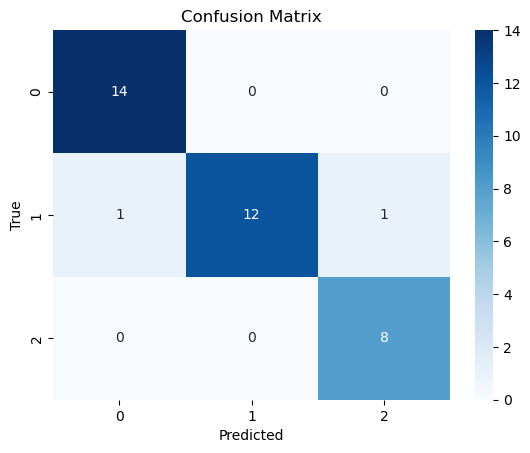


Highest accuracy(0.944) achieved with classifier: RandomForestClassifier

Model score for LogisticRegression
Accuracy  : 0.944
Precision : 0.944
Recall    : 0.944


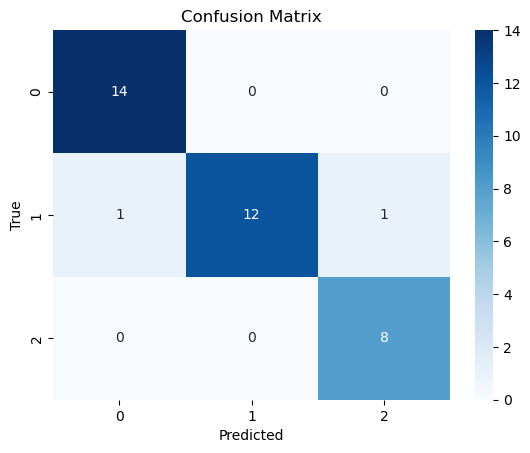


Highest accuracy(0.944) achieved with classifier: RandomForestClassifier

Model score for SVC
Accuracy  : 0.972
Precision : 0.972
Recall    : 0.972


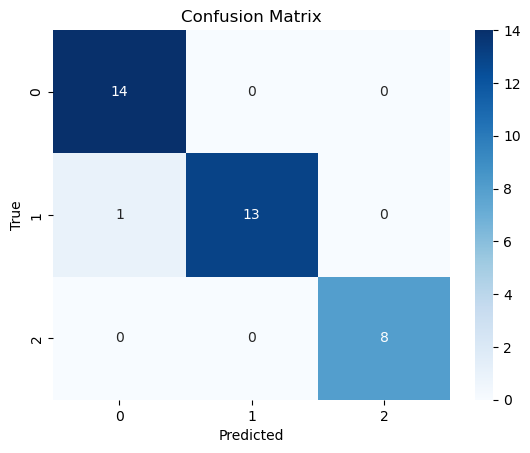


Highest accuracy(0.972) achieved with classifier: SVC

Model score for GradientBoostingClassifier
Accuracy  : 0.944
Precision : 0.944
Recall    : 0.944


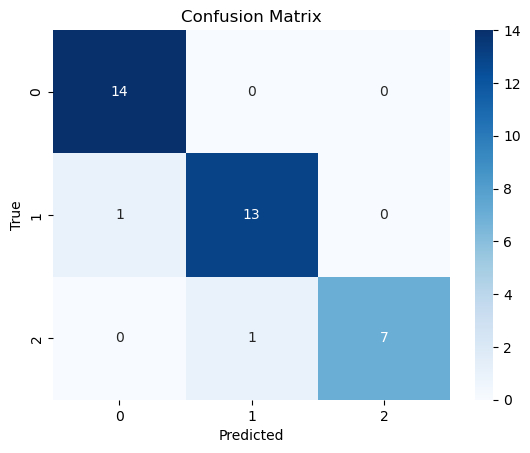


Highest accuracy(0.972) achieved with classifier: SVC

Model score for GaussianNB
Accuracy  : 0.944
Precision : 0.944
Recall    : 0.944


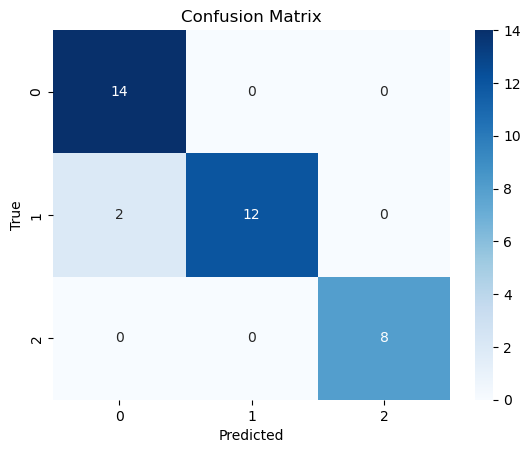


Highest accuracy(0.972) achieved with classifier: SVC


In [15]:
def main():
    
    # Define the column transformer for the pipeline
    numeric_features = slice(0, 11)  # Assuming the first 11 columns are numeric

    column_transformer_scaler = ColumnTransformer([
        ('numeric_scaler', StandardScaler(), numeric_features),
    ])

    # Create the pipeline with preprocessing and any desired machine learning model
    # We can choose different classifiers like RandomForestClassifier, LogisticRegression, 
    # SVC(Support Vector Machines), GradientBoostingClassifier, GaussianNB (Naive Bayes)
    classifiers = ['RandomForestClassifier', 'LogisticRegression', 'SVC', 
                   'GradientBoostingClassifier', 'GaussianNB']
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('preprocessing', column_transformer_scaler),
        ('feature_engineering', FeatureCreator()),
        ('classifier', LogisticRegression())
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict the cultivator for the test data
    y_pred = pipeline.predict(X_test)

    #print("STARTING MODEL COMPARISON WITH THE CULTIVATOR")
    # Compare the predicted cultivator with the actual cultivator
    for pred, actual in zip(y_pred, y_test):
        if pred == actual:
            print(f"RIGHTFULLY Predicted: {pred}, Actual: {actual}")
        else:
            print(f"WRONGFULLY predicted: {pred}, Actual: {actual}")


    print("TOP FEATURES FROM THE UNIVARIATE FEATURE METHOD")
    univariateFeatures = univariate_feature_selection(k=3)
    for i, featureIndex in enumerate(univariateFeatures):
        print("Top " + str(i+1) + " feature is: " + feature_names[featureIndex])
 
    print("\nTOP FEATURES FROM THE FEATURE IMPORTANCE METHOD")
    importanceFeatures = feature_importance(n_features=3)
    for i, featureIndex in enumerate(importanceFeatures):
        print("Top " + str(i+1) + " feature is: " + feature_names[featureIndex])

    print("\nTOP FEATURES FROM THE RECURSIVE FEATURE ELIMINATION METHOD")
    estimator = LogisticRegression(max_iter=5000)
    eliminationFeatures = recursive_feature_elimination(estimator=estimator, n_features=3)
    for i, featureIndex in enumerate(eliminationFeatures):
        print("Top " + str(i+1) + " feature is: " + feature_names[featureIndex])

    # Evaluate the model on the testing data with different classifiers
    highest_score = 0
    highest_score_message = ""
    for classifier_name in classifiers:
        classifier_class = globals()[classifier_name]
        pipeline.steps[3] = ('classifier', classifier_class())
        pipeline.fit(X_train, y_train)

        #overwrite the predict for each classifier
        y_pred = pipeline.predict(X_test)

        # Get scores for each classifier
        score = pipeline.score(X_test, y_test)
        precision = precision_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')

        #Print scores for each classifier
        print("\nModel score for " + classifier_name)
        print("Accuracy  : %.3f" % score)
        print("Precision : %.3f" % precision)
        print("Recall    : %.3f" % recall)

        # print the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()


        # Set highest score
        if score > highest_score:
            highest_score = score
            highest_score_message = '\nHighest accuracy(%.3f' % highest_score + ') achieved with classifier: ' + classifier_name

        print(highest_score_message)


if __name__ == "__main__":
    main()